<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Kaggle-Challenge/blob/main/C_LS_DS_221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries

- **category_encoders** 
- **graphviz**
- ipywidgets
- matplotlib
- numpy
- pandas
- **plotly**
- seaborn
- scikit-learn

In [14]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [15]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport 
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn **pipelines**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model **non-linear, non-monotonic** relationships and **feature interactions**

# I. Wrangle Data

In [16]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, na_values=[0, -2.000000e-08]), pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], index_col='id')
  # drop constant columns 
  df.drop(columns=['recorded_by'], inplace=True)
  # drop high cardinality columns 
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 100]
  df.drop(columns = drop_cols, inplace=True)
  # drop duplicate columns 
  dup_cols = [col for col in df.head(15).T.duplicated().index if df.head(15).T.duplicated()[col]]
  df.drop(columns=dup_cols, inplace=True)
  return df

In [17]:
df = wrangle(DATA_PATH + 'waterpumps/train_features.csv', DATA_PATH + 'waterpumps/train_labels.csv')

df_test = wrangle(DATA_PATH+'waterpumps/test_features.csv')

In [18]:
df.shape

(59399, 29)

In [19]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,True,VWC,False,1999.0,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,NaN,Other,True,2010.0,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,True,VWC,True,2009.0,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,True,VWC,True,1986.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,True,NaN,True,NaN,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [20]:
df.select_dtypes('object').nunique().sort_values()

public_meeting            2
permit                    2
status_group              3
source_class              3
quantity                  5
management_group          5
quality_group             6
waterpoint_type_group     6
waterpoint_type           7
source_type               7
payment                   7
extraction_type_class     7
payment_type              7
water_quality             8
basin                     9
source                   10
management               12
scheme_management        12
extraction_type          18
region                   21
dtype: int64

In [21]:
cutoff = 100
drop_cols = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 100]
drop_cols

[]

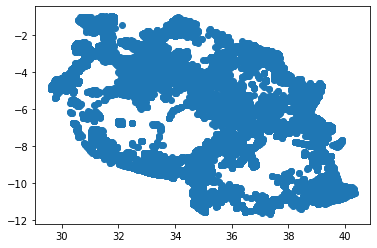

In [22]:
plt.scatter(df['longitude'], df['latitude'])

In [23]:
df[df['longitude']==0].head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [24]:
dup_cols = [col for col in df.head(15).T.duplicated().index if df.head(15).T.duplicated()[col]]
dup_cols

[]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 59399 entries, 69572.0 to 26348.0
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             17761 non-null  float64
 1   gps_height             38962 non-null  float64
 2   longitude              57587 non-null  float64
 3   latitude               57587 non-null  float64
 4   num_private            757 non-null    float64
 5   basin                  59399 non-null  object 
 6   region                 59399 non-null  object 
 7   region_code            59399 non-null  int64  
 8   district_code          59376 non-null  float64
 9   population             38019 non-null  float64
 10  public_meeting         56066 non-null  object 
 11  scheme_management      55522 non-null  object 
 12  permit                 56343 non-null  object 
 13  construction_year      38691 non-null  float64
 14  extraction_type        59399 non-null  objec

In [26]:
ProfileReport(df, minimal=True)

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# II. Split Data

In [27]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

In [28]:
X.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,True,VWC,False,1999.0,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,NaN,Other,True,2010.0,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,True,VWC,True,2009.0,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,True,VWC,True,1986.0,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,True,NaN,True,NaN,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Traing-Validation Split

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
len(X_train) + len(X_val) == len(X)

True

# III. Establish Baseline 

* Is this a regression or a classification problem?
* Because it's a **classification** problemm we need to calculate baseline accuracy based on our majority class.

In [31]:
y_train.value_counts(normalize=True)

functional                 0.542583
non functional             0.384352
functional needs repair    0.073066
Name: status_group, dtype: float64

In [32]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model(s)

- Encoder for categorical features 
- Imputer for missing values 
- StandardScaler for logistic regression

**First Model**: Logistic Regression

In [35]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)


In [36]:
model_lr.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Second Model**: Decision Tree Classifier

In [52]:
model_dt = make_pipeline(
    OrdinalEncoder(), # it's better to do ordinal encoding for a tree
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, max_depth=18)
)

In [53]:
model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group'],
                                mapping=[...
hand pump                      2
other                          3
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtyp

**Interlude: How does a tree model work?**

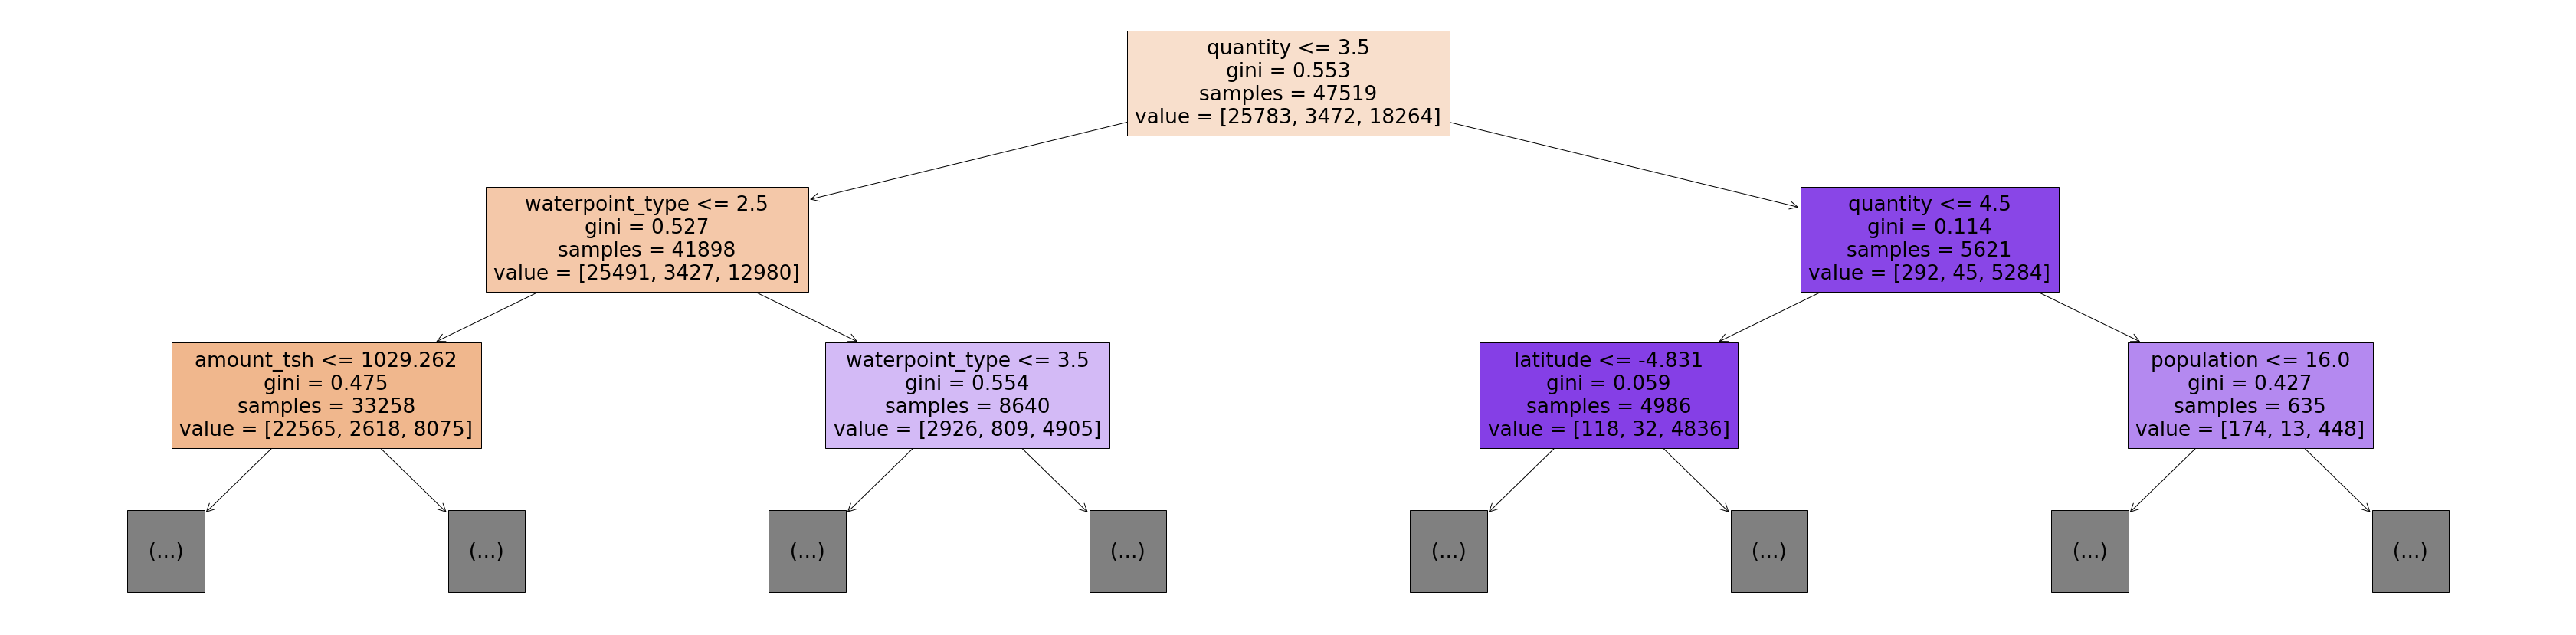

In [47]:
plt.figure(figsize=(60, 15))
plot_tree(model_dt.named_steps['decisiontreeclassifier'], max_depth=2, feature_names=X_train.columns, filled=True);

# V. Check Metrics

In [37]:
print('Logistic Regression training accuracy:', model_lr.score(X_train, y_train))
print('Logistic Regression validation accuracy:', model_lr.score(X_val, y_val))

Logistic Regression training accuracy: 0.7386939960857762
Logistic Regression test accuracy: 0.7368686868686869


In [54]:
print('Decision Tree training accuracy:', model_dt.score(X_train, y_train))
print('Decision Tree validation accuracy:', model_dt.score(X_val, y_val))

Decision Tree training accuracy: 0.9061007176076937
Decision Tree validation accuracy: 0.768013468013468


# VI. Tune Model

Let's look at the hyperparameter `max_depth`

In [48]:
model_dt.named_steps['decisiontreeclassifier'].get_depth()

38

In [50]:
depths = range(2, 38, 2)

train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

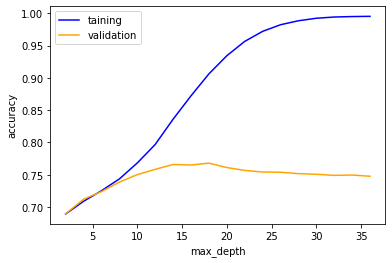

In [51]:
plt.plot(depths, train_acc, color='blue', label='taining')
plt.plot(depths, val_acc, color='orange', label='validation')

plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend();

# VII. Communciate Results 

# Review

Decision Trees are useful and powerful for predictive modeling. Try using trees as you continue to participate in the Kaggle challenge!

- Do train/validate/test split with the Tanzania Waterpumps data.
- Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. 
- Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- Get your validation accuracy score.
- Get and plot your feature importances.
- Submit your predictions to our Kaggle competition.

# Sources

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)